### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 25 ноября 2019, 15:00   
**Штраф за опоздание:** -2 балла после 15:00 25 ноября, -4 балла после 15:00 2 декабря, -6 баллов после 15:00 9 декабря  -8 баллов после 15:00 16 декабря.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0919, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

###### Задание 1 (3 балла)
Разберитесь в коде MyDecisionTreeClassifier, который уже частично реализован. Допишите код там, где написано "Ваш код". Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn. Точность проверяется на [wine](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html) и [Speed Dating Data](https://cloud.mail.ru/public/8nHV/p6J7wY1y1)

###### Задание 2 (3 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine и Speed Dating Data. 
Для этого используем numpy.

###### Задание 3 (2 балла)
Добавьте функционал, который определяет значения feature importance. Выведите 10 главных фичей под пунктом Задание 4 (уже написано ниже) для MyDecisionTreeClassifier и DecisionTreeClassifier так, чтобы сразу были видны выводы и по MyDecisionTreeClassifier, и по DecisionTreeClassifier. Используем данные Speed Dating Data.

###### Задание 4 (2 балла)
С помощью GridSearchCV или RandomSearchCV подберите наиболее оптимальные параметры для случайного леса (Выберете 2-3 параметра). Используем данные Speed Dating Data. Задание реализуйте под пунктом Задание 5 (уже написано ниже)


**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw3.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл

In [1]:
!pip install pycodestyle_magic

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
#%load_ext pycodestyle_magic
from collections import Counter

In [36]:
#%%pycodestyle


class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=None, sufficient_share=1.0, criterion='gini',  max_features=None):
        self.tree = dict()
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.sufficient_share = sufficient_share
        self.class_num = -1
        self.feature_importances_ = None
        if criterion == 'gini':
            self.G_function = self.__gini
        elif criterion == 'entropy':
            self.G_function = self.__entropy
        elif criterion == 'misclass':
            self.G_function = self.__misclass
        else:
            print('invalid criterion name')
            raise

        if max_features == 'sqrt':
            self.get_feature_ids = self.__get_feature_ids_sqrt
        elif max_features == 'log2':
            self.get_feature_ids = self.__get_feature_ids_log2
        elif max_features == None:
            self.get_feature_ids = self.__get_feature_ids_N
        else:
            print('invalid max_features name')
            raise

    def __gini(self, l_c, l_s, r_c, r_s):
        l_s = l_s.astype('float')
        r_s = r_s.astype('float')
        return 1 - (l_c**2 / l_s + r_c**2 / r_s).sum(axis=1)   # Ваш код в 1 строчку


    def __entropy(self, l_c, l_s, r_c, r_s):
        return -(l_c * np.log(l_c) / l_s + r_c * np.log(r_c) / r_s).sum(axis=1)  # Ваш код в 1 строчку

    def __misclass(self, l_c, l_s, r_c, r_s):
        return 1 - (l_c.max(axis=1) + r_c.max(axis=1)) / (l_s[0] + r_s[0]) # Ваш код в 1 строчку

    def __get_feature_ids_sqrt(self, n_feature):
        feature_ids = range(n_feature)
        np.random.shuffle(feature_ids)
        return feature_ids[:round(np.sqrt(n_feature))]  # Ваш код в 1 строчку

    def __get_feature_ids_log2(self, n_feature):
        feature_ids = range(n_feature)
        np.random.shuffle(feature_ids)
        return feature_ids[:round(np.log2(n_feature))]  # Ваш код в 1 строчку

    def __get_feature_ids_N(self, n_feature):
        return range(n_feature)  # Ваш код

    def __sort_samples(self, x, y):
        sorted_idx = x.argsort()
        return x[sorted_idx], y[sorted_idx]

    def __div_samples(self, x, y, feature_id, threshold):
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        
        # В {x_sort} кладётся отсортированный {x}, 
        # а в {y_sort} кладутся соответствующие этим отсортированным {x} значения {y}
        # {class_number} --- кол-во различных классов (кол-во различных {y})
        
        x_sort, y_sort = self.__sort_samples(x, y)
        class_num = self.class_num
        cut_size = np.int(self.min_samples_split / 2 - 1)
        
        if cut_size == 0:
            splitted_y_sort = y_sort
        else:
            splitted_y_sort = y_sort[cut_size:-cut_size]
        r_bord = np.where(splitted_y_sort[:-1] != splitted_y_sort[1:]
                                )[0] + (cut_size + 1)

        if len(r_bord) == 0:
            return np.inf, None
        
        eq_el_count = r_bord - np.append(
            np.array([cut_size]), r_bord[:-1])
        one_hot_code = np.zeros((r_bord.shape[0], class_num))
        one_hot_code[np.arange(r_bord.shape[0]), y_sort[r_bord- 1]] = 1
        class_increments = one_hot_code * eq_el_count.reshape(-1, 1)
        class_increments[0] = class_increments[0] + np.bincount(y_sort[:cut_size], minlength=class_num)

        
        ### {l_c} --- кол-во элементов каждого класса, которые попадут в левую часть разбиения
        ### {r_c} --- кол-во элементов каждого класса, которые попадут в правую часть разбиения
        ### {l_s} --- кол-во элементов, которые попадут в левую часть разбиения
        ### {r_s} --- кол-во элементов, которые попадут в правую часть разбиения
        l_c = np.cumsum(class_increments, axis=0)
        r_c = np.bincount(y_sort, minlength=class_num) - l_c
        l_s = r_bord.reshape(l_c.shape[0], 1)
        r_s = y_sort.shape[0] - l_s

        g_func = self.G_function(l_c, l_s, r_c, r_s)
        idx = np.argmin(g_func)

        left_el_id = l_s[idx][0]
        return g_func[idx], (x_sort[left_el_id - 1] + x_sort[left_el_id]) / 2.0
    
    def __fit_node(self, x, y, node_id, depth, pred_f=-1):
        
        if (self.max_depth is not None) and (depth > self.max_depth) or\
                y.shape[0] <= self.min_samples_split or\
                ((np.bincount(y).max() / y.shape[0]) >= self.sufficient_share):

            buf = np.bincount(y)
            self.tree[node_id] = (self.__class__.LEAF_TYPE, buf.argmax(),
                                  buf.astype(float) / y.size)
            return

        ids = self.get_feature_ids(x.shape[1])
        trs = np.array([self.__find_threshold(x[:, idx], y) for idx in ids])

        best_trs_idx = trs[:, 0].argmin()
        best_trs_val = trs[best_trs_idx, 1]

        l_x, r_x, l_y, r_y = self.__div_samples(x, y, ids[best_trs_idx],
                                                best_trs_val)

        if l_x.shape[0] == 0 or r_x.shape[0] == 0:
            buf = np.bincount(y)
            self.tree[node_id] = (self.__class__.LEAF_TYPE, buf.argmax(),
                                  buf.astype(float) / y.size)
            return

        self.tree[node_id] = (self.__class__.NON_LEAF_TYPE,
                              ids[best_trs_idx], best_trs_val)

        self.__fit_node(l_x, l_y, node_id * 2 + 1, depth + 1)
        self.__fit_node(r_x, r_y, node_id * 2 + 2, depth + 1)

        self.feature_importances_[best_trs_idx] += 1 / (depth**2 + 1)

    def fit(self, x, y):
        self.class_num = np.unique(y).size
        self.feature_importances_ = np.zeros(x.shape[1])
        self.__fit_node(x, y, 0, 0)
        self.feature_importances_ = \
            self.feature_importances_ / np.sum(self.feature_importances_)

    def __predict_class(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]

    def __predict_probs(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_probs(x, 2 * node_id + 1)
            else:
                return self.__predict_probs(x, 2 * node_id + 2)
        else:
            return node[2]

    def predict(self, X):
        return np.array([self.__predict_class(x, 0) for x in X])

    def predict_probs(self, X):
        return np.array([self.__predict_probs(x, 0) for x in X])

    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)

In [37]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2, max_depth=5)
clf = DecisionTreeClassifier(min_samples_split=2)

In [38]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target,
                                                    test_size=0.1, stratify=wine.target, random_state=42)

## Проверка скорости работы на wine

In [39]:
%timeit clf.fit(X_train, y_train)

613 µs ± 27.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [40]:
%timeit my_clf.fit(X_train, y_train)

6.73 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Проверка качества работы на wine

In [41]:
f1_score(y_pred=clf.predict(X_test), y_true=y_test, average='macro')

0.9474747474747475

In [42]:
f1_score(y_pred=my_clf.predict(X_test), y_true=y_test, average='macro')

0.9474747474747475

In [43]:
from sklearn.metrics import classification_report
print('Sklearn estimator: \n', classification_report(y_test, clf.predict(X_test)))
print('My estimator: \n', classification_report(y_test, my_clf.predict(X_test)))

Sklearn estimator: 
               precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.88      1.00      0.93         7
           2       1.00      1.00      1.00         5

    accuracy                           0.94        18
   macro avg       0.96      0.94      0.95        18
weighted avg       0.95      0.94      0.94        18

My estimator: 
               precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.88      1.00      0.93         7
           2       1.00      1.00      1.00         5

    accuracy                           0.94        18
   macro avg       0.96      0.94      0.95        18
weighted avg       0.95      0.94      0.94        18



## Подготовка данных Speed Dating Data 

In [44]:
speed_dating_data = pd.read_csv('data/speed-dating-experiment/SpeedDatingData.csv', encoding='cp1251')
speed_dating_data.tail()



,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
8373,552,22.0,1,44,2,21,22,14,10.0,5,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8374,552,22.0,1,44,2,21,22,13,10.0,4,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8375,552,22.0,1,44,2,21,22,19,10.0,10,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8376,552,22.0,1,44,2,21,22,3,10.0,16,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8377,552,NaN,1,44,2,21,22,2,10.0,15,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0


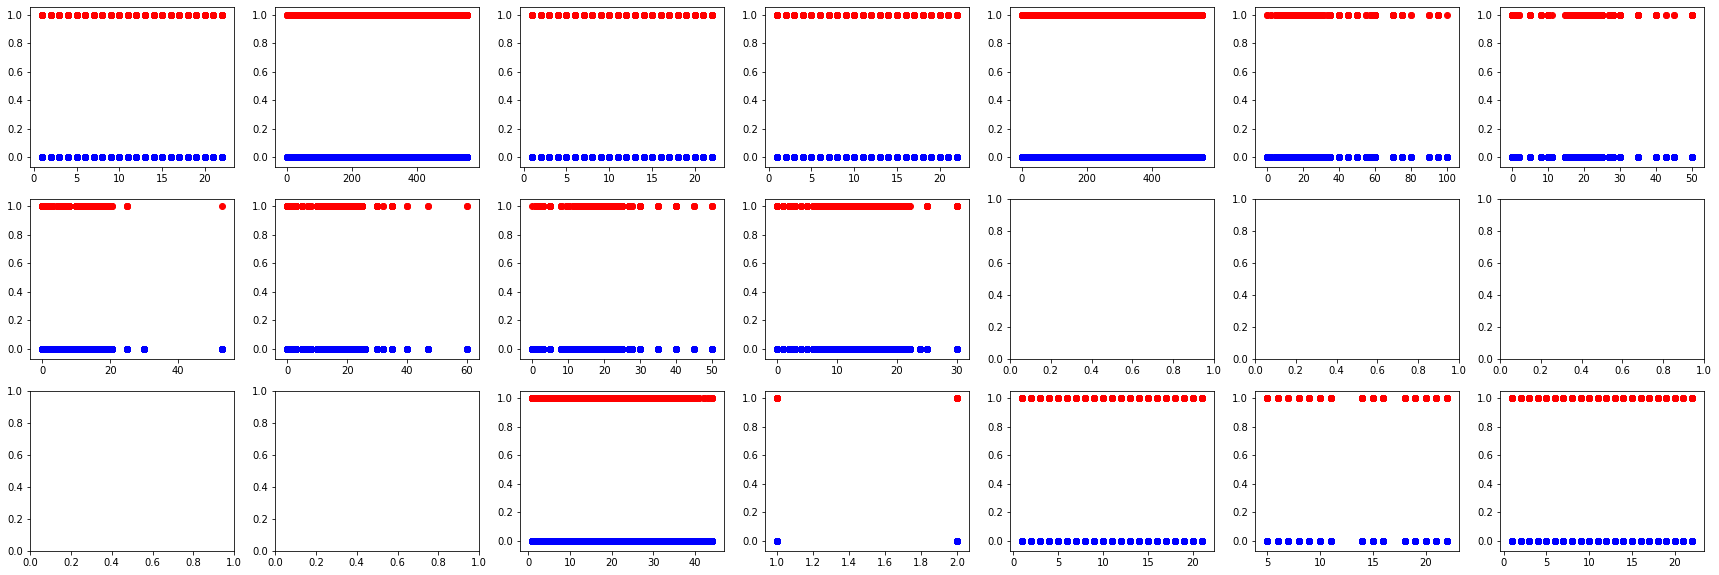

In [45]:
# Данные признаки плохо разделяют таргет

features_to_drop =[
    'positin1', # station number where started
    'iid',      # unique subject number, group(wave id gender)
    'position', # station number where met partner
    'partner',  # partner`s id number the night of event
    'pid',      # parther`s iid number
    'pf_o_att','pf_o_int','pf_o_amb','pf_o_sin','pf_o_fun','pf_o_sha',
    'field', 'from', 'zipcode', 'tuition', 'undergra', 
    'idg','condtn','wave','round','order',
]

fig, axes = plt.subplots(3, 7)
fig.set_figheight(10)
fig.set_figwidth(30)

for i, feature in enumerate(features_to_drop):
    if speed_dating_data[feature].dtype != object:
        match_0 = speed_dating_data[speed_dating_data.match == 0][feature]
        match_1 = speed_dating_data[speed_dating_data.match == 1][feature]
        axes[i//7, i%7].scatter(match_0, y=np.zeros(match_0.shape[0]), c='b')
        axes[i//7, i%7].scatter(match_1, y=np.ones(match_1.shape[0]), c='r')

In [46]:
speed_dating_data.drop(features_to_drop, axis=1, inplace=True)


speed_dating_data['income'] = speed_dating_data['income'].str.replace(',', '').astype(np.float).fillna(-1)
speed_dating_data['mn_sat'] = speed_dating_data['mn_sat'].str.replace(',', '').astype(np.float).fillna(0)

speed_dating_data.drop(['imprace', 'imprelig', 'career', 'sports', 'tvsports',
                        'dining', 'museums', 'art', 'hiking', 'gaming',
                        'clubbing', 'reading', 'tv', 'theater', 'movies',
                        'concerts', 'music', 'shopping', 'yoga', 'exphappy', 'goal'], axis = 1, inplace=True)

speed_dating_data.fillna(-1, inplace=True)

In [47]:
# Из здравого смысла выберем наиболее подходящие признаки, и те, что не входят в выкинутые выше

cols = ['age', 'age_o', 'amb', 'amb_o', 'attr', 'attr_o',\
        'date', 'dec', 'fun', 'fun_o', 'income', 'income',\
        'int_corr', 'intel', 'intel_o', 'like', 'like_o',\
        'match_es', 'met', 'met_o', 'mn_sat', 'prob', 'prob_o',\
        'race_o', 'shar', 'shar_o', 'sinc', 'sinc_o', 'them_cal', 'you_call']

X = speed_dating_data[cols].values
y = speed_dating_data['match'].values

## Проверка скорости работы на Speed Dating Data 

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
clf = DecisionTreeClassifier(min_samples_split=2)
%timeit clf.fit(X_train, y_train)

23.4 ms ± 118 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [50]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
%timeit my_clf.fit(X_train, y_train)

208 ms ± 2.48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Проверка качества работы на Speed Dating Data

In [51]:
preds = clf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      1389
           1       0.65      0.61      0.63       287

    accuracy                           0.88      1676
   macro avg       0.78      0.77      0.78      1676
weighted avg       0.87      0.88      0.87      1676



In [52]:
preds = my_clf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1389
           1       0.77      0.42      0.55       287

    accuracy                           0.88      1676
   macro avg       0.83      0.70      0.74      1676
weighted avg       0.87      0.88      0.86      1676



## Задание 3

In [53]:
ids = (-clf.feature_importances_).argsort()[:10]
feat_imp = pd.DataFrame()
feat_imp['Features'] = np.array(cols)[ids]
feat_imp['Importance'] = clf.feature_importances_[ids]

feat_imp

,Features,Importance
0,dec,0.271892
1,attr_o,0.185840
2,like_o,0.076133
3,int_corr,0.042452
4,age_o,0.030356
5,prob_o,0.029814
6,prob,0.024086
7,amb_o,0.021729
8,fun_o,0.020347
9,shar,0.019562


In [54]:
ids = (-my_clf.feature_importances_).argsort()[:10]
feat_imp = pd.DataFrame()
feat_imp['Features'] = np.array(cols)[ids]
feat_imp['Importance'] = clf.feature_importances_[ids]

feat_imp

,Features,Importance
0,dec,0.271892
1,attr_o,0.185840
2,like_o,0.076133
3,prob_o,0.029814
4,shar_o,0.017310
5,age_o,0.030356
6,fun_o,0.020347
7,match_es,0.015819
8,intel_o,0.011138
9,age,0.015884


## Задание 4

## Задание 5

In [60]:
import time
clf = RandomForestClassifier(n_estimators=20)
param_grid = {  'n_estimators':[5,10, 20, 50],
                'min_samples_split':[2, 5, 10],
                'max_depth':[5, 10, 50, 100],
                 'criterion':['gini', 'entropy'],
                 'max_features': [None, 5, 10, 20]}
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=3, iid=False, scoring='f1_macro', n_jobs=5)

grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=20, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid=Fal

In [61]:
grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 20,
 'min_samples_split': 2,
 'n_estimators': 50}

In [62]:
grid_search.best_score_

0.8260837498499769